# If Fitting with GA
**Written by Akwasi Darkwah Akwaboah**<br>
**01/20/2020**



***Clamping Protocol***

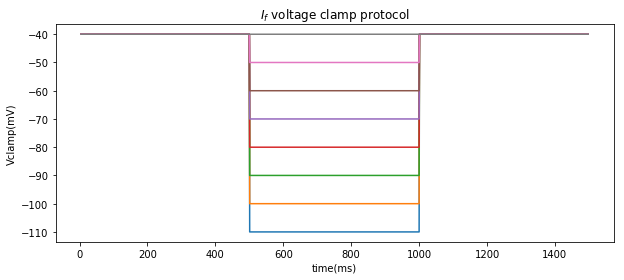

In [11]:
import numpy as np
import matplotlib.pyplot as plt

Vcm = np.arange(-110, -39, 10)
Vhold = -40  #mV
dt = 1  # time step
tStart = 0
tEnd = 1500
nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
Vm = np.zeros((nStep + 1, 1), dtype=np.float)
plot_time = np.empty((nStep, 1), dtype=np.float)
plot_Vm = np.empty((nStep, len(Vcm)), dtype=np.float)
t = np.linspace(tStart, tEnd, nStep + 1)
i = 0  #column selector

for Vc in Vcm:
    tNow = tStart
    Vm[0] = Vhold
    for iStep in np.arange(nStep):
            Vm[iStep+1] = (0 < tNow < 500)* Vhold + (500 <= tNow < 1000 )*Vc + (tNow >= 1000 )*Vhold
            plot_Vm[iStep, i] = Vm[iStep]
            plot_time[iStep] = tNow
            tNow = tStart + iStep * dt
    i = i + 1 #increment to next clamp column

plt.figure(figsize = (10,4))
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{f}$ voltage clamp protocol')
#plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='lower left')

#plt.grid()
plt.show()

**If function and initial stewart model plot**

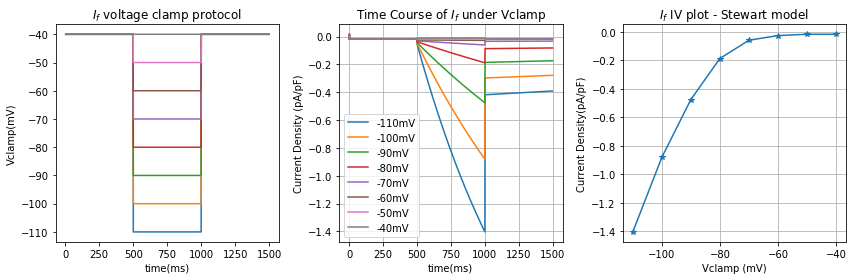

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#If function 
def If_func(Gfk, Gfna, ayss, byss, cyss, a_ay, b_ay, a_by, b_by, a_tau):
    #constants
    dt = 1 #time steps
    tStart = 0
    tEnd = 1500
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    t = np.linspace(tStart, tEnd, nStep + 1)
    Vcm = np.arange(-110, -39, 10)
    Vhold = -50  #mV
    
    K_o = 5.4 #mM
    Na_o = 140 #mM

    K_i = 136.9896086978 #mM
    Na_i = 8.5447311020  #mM
    R = 8.314 #J K^-1 mol^-1
    T = 310 #K
    F = 96.4867 #C.mmol^-1
    Gfk = 0.0234346
    Gfna = 0.0145654
    Cmem = 1.38e-10

    Ek = ((R*T)/F)*np.log(K_o/K_i)
    Ena = ((R*T)/F)*np.log(Na_o/Na_i)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_y = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_y = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_If = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)
    i = 0 #column counter

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vhold
        # initial condition
        y = 0.0184308075
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (0 < tNow < 500)* Vhold + (500 <= tNow < 1000 )*Vc + (tNow >= 1000 )*Vhold
            yss = ayss/(1 + np.exp((Vm[iStep] + byss)/cyss))
            alpha_y = np.exp(-(a_ay + (b_ay*Vm[iStep])))
            beta_y = np.exp(a_by + (b_by*Vm[iStep]))
            tau_y = a_tau/(alpha_y + beta_y)
            dy = ((yss - y)/ tau_y)*dt

            if_k = Gfk * y * (Vm[iStep] - Ek)
            if_na = Gfna * y * (Vm[iStep] - Ena)
            If = if_k + if_na
            Im = If + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_y[iStep, i] = y
            plot_If[iStep, i] = If
            plot_tau_y[iStep, i] = tau_y
            plot_time[iStep] = tNow
            plot_Im[iStep] = Im

            y = y+dy
            tNow = tStart + iStep * dt
        i = i + 1
    If_peaks = np.min(plot_If, axis=0)
    return If_peaks, plot_time, plot_If

Vcm = np.arange(-110, -39, 10)
If_pks, time, plt_If = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{f}$ voltage clamp protocol')
#plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='lower left')
#plt.grid()
#plt.show()


plt.subplot(1,3,3)
plt.plot(Vcm, If_pks, '-*')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Current Density(pA/pF)')
plt.title('$I_f$ IV plot - Stewart model')
plt.grid()
#plt.show()


#plt.figure()
plt.subplot(1,3,2)
plt.plot(time, plt_If)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under Vclamp')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.tight_layout()
plt.show()

***If function for GA***

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def If_func(Gfk, Gfna, ayss, byss, cyss, a_ay, b_ay, a_by, b_by, a_tau):
    #constants
    dt = 1 #time steps
    tStart = 0
    tEnd = 1500
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    t = np.linspace(tStart, tEnd, nStep + 1)
    Vcm = np.arange(-110, -39, 10)
    Vhold = -40  #mV
    
    K_o = 5.4 #mM
    Na_o = 140 #mM

    K_i = 136.9896086978 #mM
    Na_i = 8.5447311020  #mM
    R = 8.314 #J K^-1 mol^-1
    T = 310 #K
    F = 96.4867 #C.mmol^-1
    Gfk = 0.0234346
    Gfna = 0.0145654
    Cmem = 1.38e-10

    Ek = ((R*T)/F)*np.log(K_o/K_i)
    Ena = ((R*T)/F)*np.log(Na_o/Na_i)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_y = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_y = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_If = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)
    i = 0 #column counter

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vhold
        # initial condition
        y = 0.0184308075
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (0 < tNow < 500)* Vhold + (500 <= tNow < 1000 )*Vc + (tNow >= 1000 )*Vhold
            yss = ayss/(1 + np.exp((Vm[iStep] + byss)/cyss))
            alpha_y = np.exp(-(a_ay + (b_ay*Vm[iStep])))
            beta_y = np.exp(a_by + (b_by*Vm[iStep]))
            tau_y = a_tau/(alpha_y + beta_y)
            dy = ((yss - y)/ tau_y)*dt

            if_k = Gfk * y * (Vm[iStep] - Ek)
            if_na = Gfna * y * (Vm[iStep] - Ena)
            If = if_k + if_na
            Im = If + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_y[iStep, i] = y
            plot_If[iStep, i] = If
            plot_tau_y[iStep, i] = tau_y
            plot_time[iStep] = tNow
            plot_Im[iStep] = Im

            y = y+dy
            tNow = tStart + iStep * dt
        i = i + 1
    If_peaks = np.min(plot_If, axis=0)
    return If_peaks, plot_time, plot_If

**GA**

generation:  0


C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in true_divide
C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in add
C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in add
C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in multiply


1
[56]
56
23.926262705132928
20
Runtime:  0.6926447683334118 mins
[ 1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
              inf  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  6.19795203e+001  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  9.43010730e+001  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  3.92216943e+001  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1.00000000e+100  1.00000000e+100
  1.00000000e+100  1.00000000e+100  1

C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in power


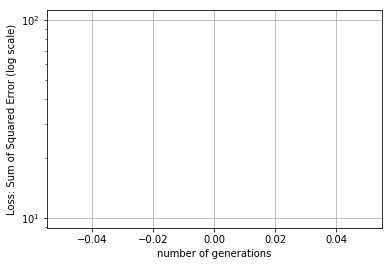

[ 9.98534066e-01  7.75687007e-01  2.40593984e+00  8.36568051e+01
  2.84555026e+00 -1.89139568e-01  1.65131902e-02  4.06559810e+00
  6.35616989e-01  3.98841326e+03]


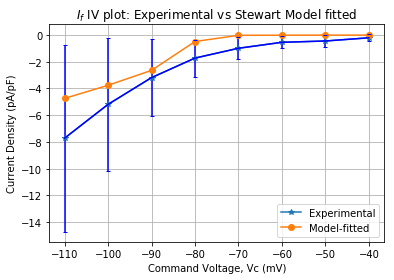

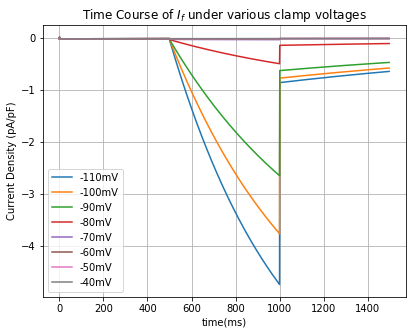

generation:  1
2
[43 83]
43
7.06010545559049
20
generation:  2
2
[37 77]
37
3.396745849988405
20
generation:  3
2
[39 79]
39
3.1705802446380327
20
generation:  4
2
[26 66]
26
2.2398636074068845
20
generation:  5
2
[49 89]
49
2.028472492507051
20
Runtime:  4.141546298333075 mins
[ 2.23986361e+00  2.23986361e+00  2.23986361e+00  2.23986361e+00
  2.23986361e+00  2.23986361e+00  2.23986361e+00  2.23986361e+00
  2.23986361e+00  2.23986361e+00  2.23986361e+00  2.23986361e+00
  2.23986361e+00  2.23986361e+00  2.23986361e+00  2.23986361e+00
  2.23986361e+00  2.23986361e+00  2.23986361e+00  2.23986361e+00
  6.56836341e+00  2.23934567e+00  2.23986361e+00  2.23986361e+00
  2.23986361e+00  7.54245864e+00  2.23986361e+00  2.25449284e+00
  2.21899157e+00  2.23946593e+00  2.25061699e+00  2.14682603e+00
  3.08867205e+00  2.22241915e+00  4.29398009e+00  2.23521024e+00
  2.23986361e+00  2.29276813e+00  5.77666940e+00  1.76909346e+01
  2.23952441e+00  2.22971468e+00  7.37905316e+00  2.22979290e+00
  2.23

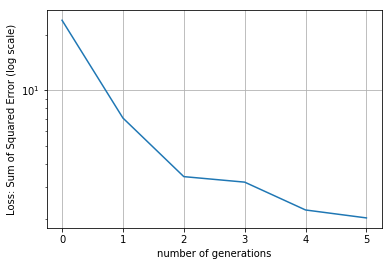

[9.98534066e-01 7.75687007e-01 3.59246552e+00 8.06252897e+01
 4.34321003e+00 1.26056448e-01 1.95242397e-02 4.06559810e+00
 6.35616989e-01 3.98841326e+03]


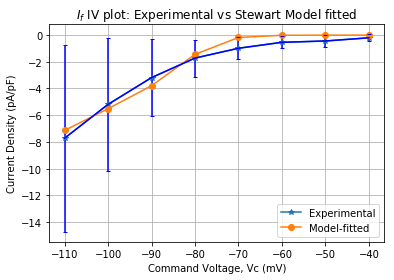

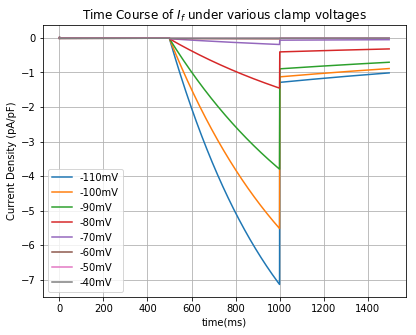

generation:  6
2
[23 63]
23
1.4704573958735954
20
generation:  7
2
[47 87]
47
1.4691437659722488
20
generation:  8
2
[31 71]
31
1.3635014353814632
20
generation:  9
2
[23 63]
23
1.1710708924569069
20
generation:  10
2
[24 64]
24
0.8778351422053734
20
Runtime:  7.718648939999791 mins
[ 1.17107089e+00  1.17107089e+00  1.17107089e+00  1.17107089e+00
  1.17107089e+00  1.17107089e+00  1.17107089e+00  1.17107089e+00
  1.17107089e+00  1.17107089e+00  1.17107089e+00  1.17107089e+00
  1.17107089e+00  1.17107089e+00  1.17107089e+00  1.17107089e+00
  1.17107089e+00  1.17107089e+00  1.17107089e+00  1.17107089e+00
  1.16970835e+00  1.16924237e+00  1.17107089e+00  1.80419803e+01
 -1.00000000e+11  1.38893257e+00  1.22553554e+00  1.17268790e+00
  1.08885991e+00  1.20652793e+00  1.19553590e+00  1.17107089e+00
  1.17107089e+00  1.17107089e+00  1.25219741e+00  1.17107089e+00
  1.12759451e+00  1.29049205e+01  1.17212755e+00  1.20367427e+00
  1.61591216e+00  1.17107089e+00  1.17107089e+00  9.62998318e-01
 

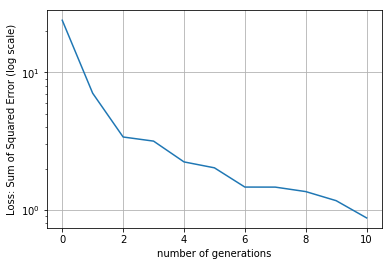

[9.98534066e-01 7.67772991e-01 3.76281075e+00 7.96751029e+01
 8.05408487e+00 1.26056448e-01 1.95242397e-02 4.06559810e+00
 6.35616989e-01 3.98604376e+03]


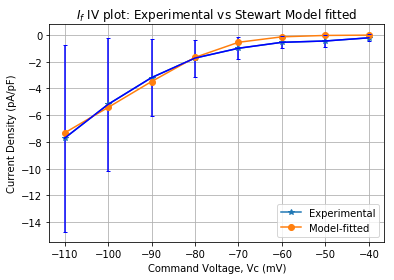

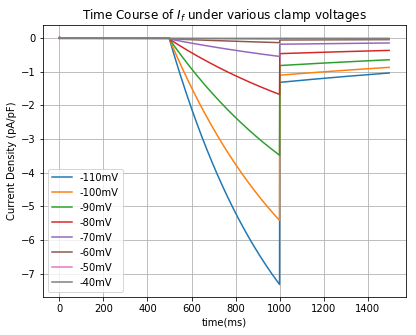

generation:  11
2
[46 86]
46
0.7368693855734427
20
generation:  12
2
[26 66]
26
0.6965346909016467
20
generation:  13
2
[42 82]
42
0.6161723493013095
20
generation:  14
2
[24 64]
24
0.5134285933873671
20
generation:  15
2
[48 88]
48
0.4646700554177543
20
Runtime:  11.087384784999692 mins
[ 5.13428593e-01  5.13428593e-01  5.13428593e-01  5.13428593e-01
  5.13428593e-01  5.13428593e-01  5.13428593e-01  5.13428593e-01
  5.13428593e-01  5.13428593e-01  5.13428593e-01  5.13428593e-01
  5.13428593e-01  5.13428593e-01  5.13428593e-01  5.13428593e-01
  5.13428593e-01  5.13428593e-01  5.13428593e-01  5.13428593e-01
  5.13428593e-01  5.13428593e-01  2.30842577e+01  2.63739473e+01
  5.96850308e-01  5.13428593e-01  5.19247872e-01  1.64999500e+01
  5.13012946e-01  5.13428593e-01  5.13428593e-01  2.25265694e+01
  2.09849200e+01  5.11194909e-01  1.35016533e+00  5.13992888e-01
  8.21182575e+00  5.15083491e-01  5.13428593e-01  5.13428593e-01
  5.13428593e-01  2.41006925e+00  5.13428593e-01  1.46207830e

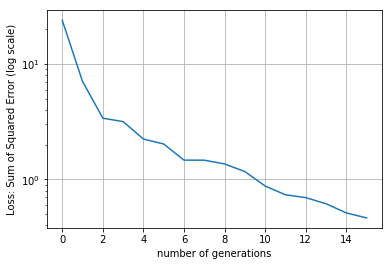

[9.98534066e-01 7.75687007e-01 3.76281075e+00 7.96751029e+01
 1.18253314e+01 1.26056448e-01 2.01103178e-02 4.06559810e+00
 6.84568511e-01 3.94384790e+03]


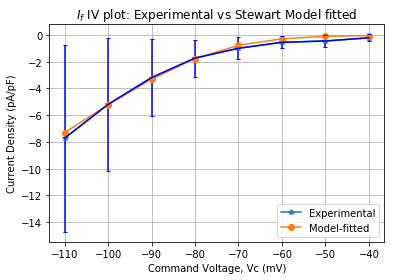

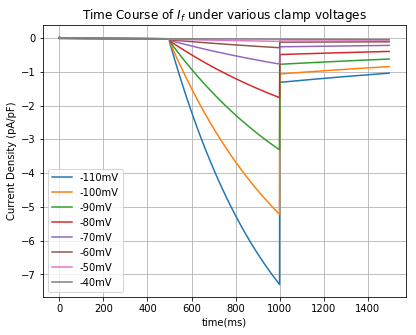

generation:  16
2
[32 72]
32
0.3920269493424428
20
generation:  17
2
[36 76]
36
0.37737034925596963
20
generation:  18
2
[47 87]
47
0.3706932584817729
20
generation:  19
2
[50 90]
50
0.33199181999079286
20
generation:  20
2
[31 71]
31
0.3047036351685005
20
Runtime:  14.035024006666694 mins
[ 3.31991820e-01  3.31991820e-01  3.31991820e-01  3.31991820e-01
  3.31991820e-01  3.31991820e-01  3.31991820e-01  3.31991820e-01
  3.31991820e-01  3.31991820e-01  3.31991820e-01  3.31991820e-01
  3.31991820e-01  3.31991820e-01  3.31991820e-01  3.31991820e-01
  3.31991820e-01  3.31991820e-01  3.31991820e-01  3.31991820e-01
  3.31991820e-01  1.86423001e+00  3.31991820e-01  5.55797028e-01
  5.32968365e-01  5.24872875e-01  3.28906040e-01  3.37922714e-01
  3.32012689e-01  3.31991820e-01  4.92170553e-01 -1.00000000e+11
  1.99252164e+00  3.31991820e-01  3.28152356e-01  3.36090142e-01
  3.31991820e-01  3.66559208e+01  3.31991820e-01  3.31991820e-01
  3.31991820e-01  4.30962111e-01  3.31991820e-01  3.9238234

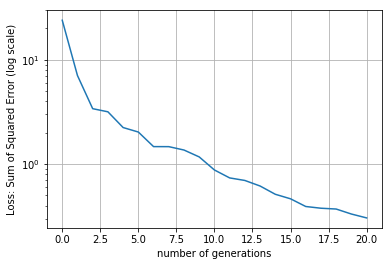

[9.98534066e-01 7.75687007e-01 3.63640795e+00 7.96751029e+01
 1.47767220e+01 1.26056448e-01 2.09306224e-02 4.06559810e+00
 6.35616989e-01 3.94384790e+03]


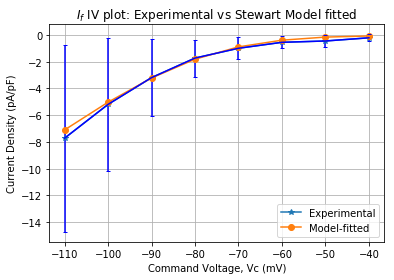

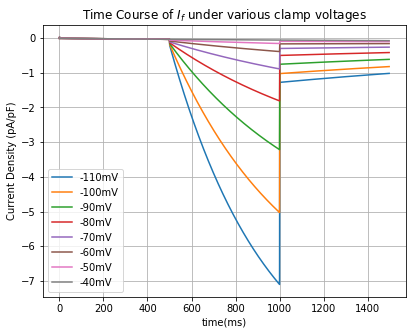

generation:  21
2
[34 74]
34
0.2757927698365556
20
generation:  22
2
[55 95]
55
0.26606070478562494
20
generation:  23
2
[55 95]
55
0.24812751025679924
20
generation:  24
2
[27 67]
27
0.20678189009328576
20
generation:  25
2
[39 79]
39
0.20554147837467213
20
Runtime:  16.97142479833322 mins
[ 2.06781890e-01  2.06781890e-01  2.06781890e-01  2.06781890e-01
  2.06781890e-01  2.06781890e-01  2.06781890e-01  2.06781890e-01
  2.06781890e-01  2.06781890e-01  2.06781890e-01  2.06781890e-01
  2.06781890e-01  2.06781890e-01  2.06781890e-01  2.06781890e-01
  2.06781890e-01  2.06781890e-01  2.06781890e-01  2.06781890e-01
  2.82718595e-01  1.48273389e+01  2.06803568e-01  2.06781890e-01
  2.06794456e-01  2.06781890e-01  2.06813497e-01  1.68236059e+00
  1.56528086e+00  2.23625816e-01  2.07332154e-01  2.53674702e-01
  2.06781890e-01  6.19773473e+00  2.71736497e-01  2.06806737e-01
  4.33138510e+00  2.06802461e-01  1.70030884e+00 -1.00000000e+11
  2.06781890e-01  2.06781890e-01  2.06798189e-01  2.488595

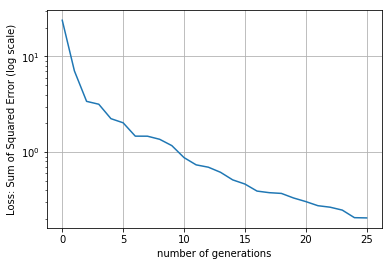

[9.98534066e-01 7.75687007e-01 3.76281075e+00 8.15554085e+01
 1.63815899e+01 8.08746343e-02 2.15724382e-02 4.06559810e+00
 6.74975085e-01 3.91599369e+03]


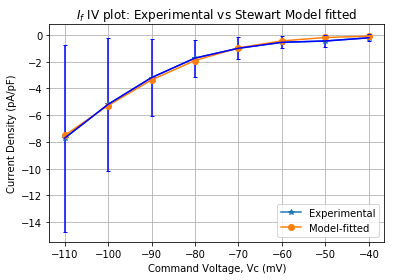

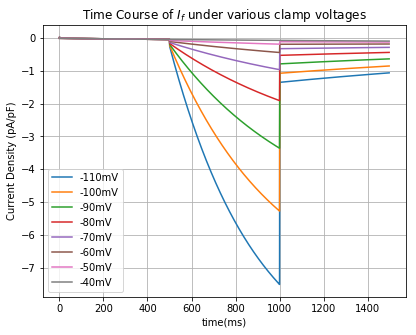

generation:  26
2
[46 86]
46
0.20532453955954294
20
generation:  27
2
[40 80]
40
0.20501353627304608
20
generation:  28
2
[45 85]
45
0.2050135362610528
20
generation:  29
2
[51 91]
51
0.2049635078397677
20
generation:  30
2
[39 79]
39
0.20485602984085832
20
Runtime:  19.923936436666796 mins
[ 2.04963508e-01  2.04963508e-01  2.04963508e-01  2.04963508e-01
  2.04963508e-01  2.04963508e-01  2.04963508e-01  2.04963508e-01
  2.04963508e-01  2.04963508e-01  2.04963508e-01  2.04963508e-01
  2.04963508e-01  2.04963508e-01  2.04963508e-01  2.04963508e-01
  2.04963508e-01  2.04963508e-01  2.04963508e-01  2.04963508e-01
  2.04963508e-01  2.18185106e-01  2.04998659e-01  2.04937873e-01
  3.62706841e+01  2.04963508e-01  2.20644323e-01  2.04963508e-01
  2.04963508e-01  2.47415989e-01  2.04963508e-01  2.04963508e-01
  2.89534029e-01  2.07572773e+01  2.04963508e-01  2.04963508e-01
  2.05011331e-01  2.35514867e-01  4.90171110e-01 -1.00000000e+11
  4.53918046e-01  2.04963508e-01  2.04963508e-01  2.453432

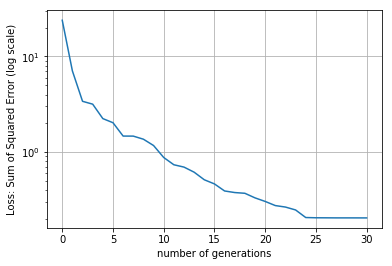

[9.98534066e-01 7.75687007e-01 5.16755590e+00 8.15554085e+01
 1.62566736e+01 8.08746343e-02 2.15724382e-02 6.40459649e+00
 6.00410530e-01 3.92805549e+03]


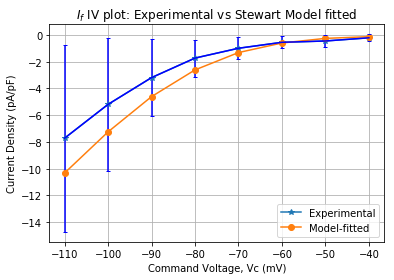

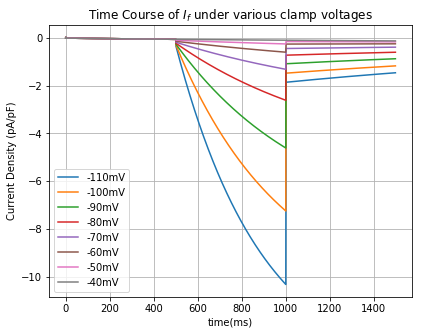

generation:  31
2
[40 80]
40
0.2005982872504573
20
generation:  32
2
[38 78]
38
0.1989521631347933
20
generation:  33
2
[28 68]
28
0.19851485255522253
20
generation:  34
2
[41 81]
41
0.19832060901061202
20
generation:  35
2
[55 95]
55
0.19790553989104537
20
Runtime:  23.04898289166643 mins
[ 1.98320609e-01  1.98320609e-01  1.98320609e-01  1.98320609e-01
  1.98320609e-01  1.98320609e-01  1.98320609e-01  1.98320609e-01
  1.98320609e-01  1.98320609e-01  1.98320609e-01  1.98320609e-01
  1.98320609e-01  1.98320609e-01  1.98320609e-01  1.98320609e-01
  1.98320609e-01  1.98320609e-01  1.98320609e-01  1.98320609e-01
  3.95453162e+00  1.98435112e-01  1.40797130e+01  2.06239259e+00
  1.44644297e+00  1.98348930e-01  1.04390770e+01  6.82035314e+00
  2.87438824e+00  2.66895995e-01  1.98320609e-01  1.98320609e-01
  1.98491149e-01  3.78310555e+01  1.02183663e+01  2.19291297e-01
  2.07102958e-01  1.98280364e-01  1.85247223e+00  2.21008111e+00
  1.98320609e-01  1.98319868e-01  1.98320609e-01  1.9832060

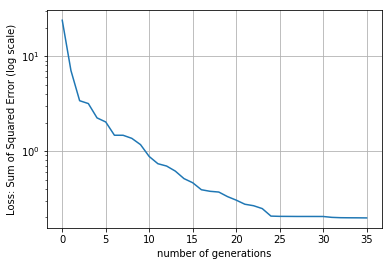

[9.98534066e-01 7.75687007e-01 3.76800706e+00 8.18556724e+01
 1.62566736e+01 8.08746343e-02 2.15724382e-02 7.66027459e+00
 6.00410530e-01 3.86655157e+03]


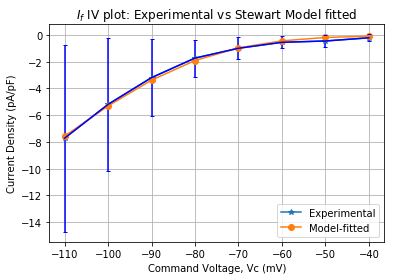

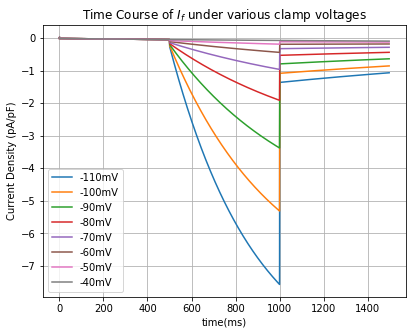

generation:  36
2
[57 97]
57
0.1948034117412626
20
generation:  37
2
[45 85]
45
0.19303107484528603
20
generation:  38
2
[57 97]
57
0.19134869673516347
20
generation:  39
2
[32 72]
32
0.1911882804361449
20
generation:  40
2
[36 76]
36
0.1895643241017359
20
Runtime:  26.245505189999918 mins
[ 1.91188280e-01  1.91188280e-01  1.91188280e-01  1.91188280e-01
  1.91188280e-01  1.91188280e-01  1.91188280e-01  1.91188280e-01
  1.91188280e-01  1.91188280e-01  1.91188280e-01  1.91188280e-01
  1.91188280e-01  1.91188280e-01  1.91188280e-01  1.91188280e-01
  1.91188280e-01  1.91188280e-01  1.91188280e-01  1.91188280e-01
  1.51660411e+01  1.91355199e-01  2.39060998e-01  2.53183833e+01
  2.11202479e-01  1.91342966e-01  1.69169717e+00  2.91045410e+00
  6.19779868e+00  1.91710482e-01  1.91188280e-01  1.92232762e-01
  1.91183108e-01  1.91771001e-01  1.91188280e-01  1.26790148e+01
 -1.00000000e+11  1.91454252e-01  1.91188280e-01  1.91188281e-01
  1.28804738e+00  2.01435451e-01  7.30216370e-01  1.4099355

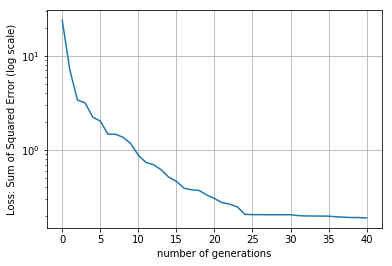

[9.98534066e-01 7.75687007e-01 3.76800706e+00 8.28063260e+01
 1.62566736e+01 8.08746343e-02 2.10581510e-02 8.16107265e+00
 6.00410530e-01 3.87139095e+03]


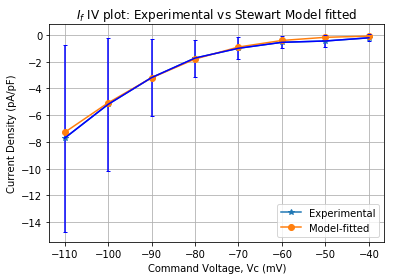

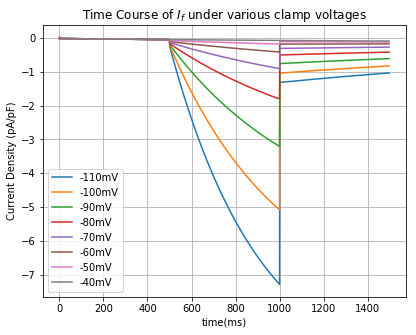

generation:  41
2
[51 91]
51
0.18289282273042534
20
generation:  42
2
[41 81]
41
0.18191512035266844
20
generation:  43
2
[49 89]
49
0.1819151191074834
20
generation:  44
32
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 26 33 36 44
 50 56 66 73 76 84 90 96]
0
0.1819151191074834
20
generation:  45
2
[39 79]
39
0.18093280889006155
20
Runtime:  29.36715753666649 mins
[ 1.81915119e-01  1.81915119e-01  1.81915119e-01  1.81915119e-01
  1.81915119e-01  1.81915119e-01  1.81915119e-01  1.81915119e-01
  1.81915119e-01  1.81915119e-01  1.81915119e-01  1.81915119e-01
  1.81915119e-01  1.81915119e-01  1.81915119e-01  1.81915119e-01
  1.81915119e-01  1.81915119e-01  1.81915119e-01  1.81915119e-01
  1.81915121e-01  1.81869430e-01  4.26240768e+00  2.80107326e-01
  2.01820328e-01  1.80686363e+01  1.48595773e+01  4.73486603e+00
  1.81915120e-01  5.35538980e-01  1.82380017e-01  1.82117395e-01
  2.18904597e+01  1.84234532e-01  1.87091431e-01  2.86516027e+01
  1.81915119e-01  6.87335057e-01 

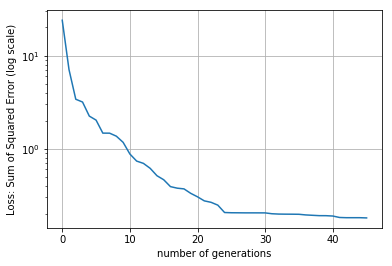

[9.98534066e-01 7.75687007e-01 3.78271618e+00 8.41979401e+01
 1.62566736e+01 8.08746343e-02 2.15724382e-02 8.16107265e+00
 5.84970677e-01 3.81358932e+03]


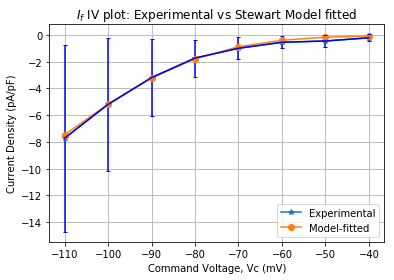

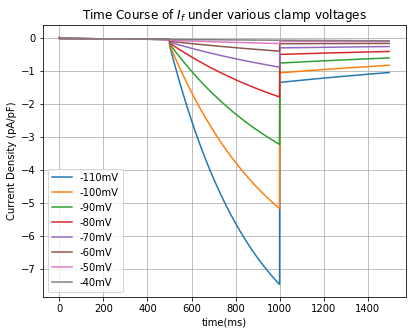

generation:  46
2
[56 96]
56
0.17946000092453723
20
generation:  47
2
[53 93]
53
0.17944155782107418
20
generation:  48
2
[44 84]
44
0.179327374055044
20
generation:  49
2
[53 93]
53
0.17932736979573832
20
generation:  50
2
[31 71]
31
0.17728437620923973
20
Runtime:  32.47157552166657 mins
[ 1.79327370e-01  1.79327370e-01  1.79327370e-01  1.79327370e-01
  1.79327370e-01  1.79327370e-01  1.79327370e-01  1.79327370e-01
  1.79327370e-01  1.79327370e-01  1.79327370e-01  1.79327370e-01
  1.79327370e-01  1.79327370e-01  1.79327370e-01  1.79327370e-01
  1.79327370e-01  1.79327370e-01  1.79327370e-01  1.79327370e-01
  1.82952100e-01  2.61085495e+00  7.00866383e-01  8.31353910e+00
  1.79327370e-01  2.34792168e+00  1.83332123e-01  1.79721517e-01
  3.02227422e+00  1.96563449e-01  1.94136451e-01 -1.00000000e+11
  1.79327370e-01  1.79321930e-01  2.34857127e+00  1.89922990e-01
  1.79327370e-01  1.79327370e-01  7.92366245e+00  1.69129392e+01
  4.97461515e-01  1.12798246e+01  2.42801759e-01  1.7982436

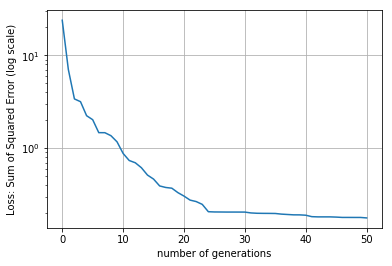

[9.98534066e-01 7.75687007e-01 3.78271618e+00 8.30144447e+01
 1.66012181e+01 8.08746343e-02 2.15724382e-02 8.16107265e+00
 5.58648948e-01 3.82096273e+03]


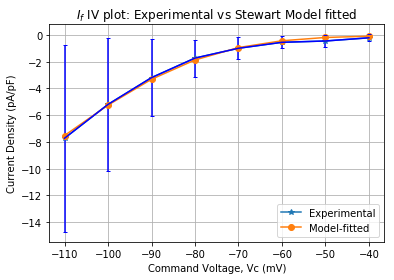

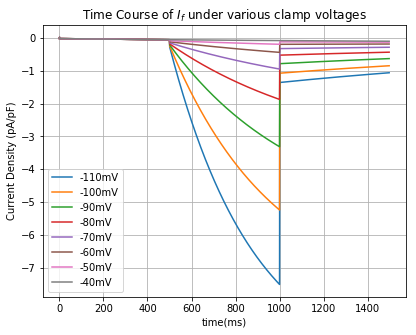

generation:  51
2
[29 69]
29
0.17633393145140594
20
generation:  52
2
[26 66]
26
0.1763338949329558
20
generation:  53
2
[43 83]
43
0.17621241047555328
20
generation:  54
38
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 26
 38 42 51 56 57 60 62 63 66 78 82 91 96 97]
0
0.17621241047555328
20
generation:  55
2
[21 61]
21
0.1754907161795264
20
Runtime:  35.599319851666706 mins
[ 1.76212410e-01  1.76212410e-01  1.76212410e-01  1.76212410e-01
  1.76212410e-01  1.76212410e-01  1.76212410e-01  1.76212410e-01
  1.76212410e-01  1.76212410e-01  1.76212410e-01  1.76212410e-01
  1.76212410e-01  1.76212410e-01  1.76212410e-01  1.76212410e-01
  1.76212410e-01  1.76212410e-01  1.76212410e-01  1.76212410e-01
  1.79464781e-01 -1.00000000e+11  1.03731334e+00  1.76212410e-01
  2.00429344e+00  1.76212410e-01  1.76212410e-01  1.76212410e-01
  1.76212410e-01  1.76212410e-01  1.38172043e+00  1.76212410e-01
  1.76212410e-01  1.76212410e-01  2.31769087e-01  1.76212437e-01
  1.49424042e+

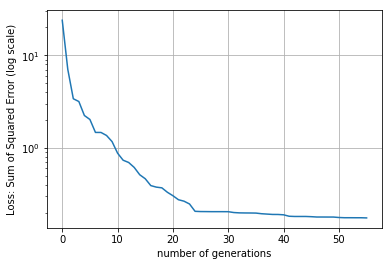

[9.98534066e-01 7.75687007e-01 3.78271618e+00 8.30727413e+01
 1.64711941e+01 8.08746343e-02 2.15724382e-02 8.16107265e+00
 5.12514619e-01 3.82125523e+03]


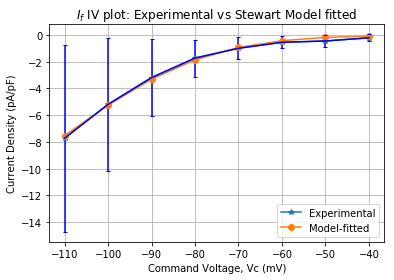

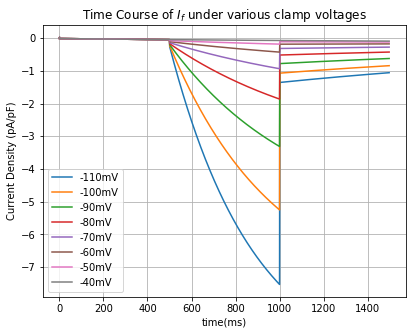

generation:  56
2
[44 84]
44
0.1754906247952196
20
generation:  57
2
[21 61]
21
0.17539841581064333
20
generation:  58
2
[48 88]
48
0.1753979360764804
20
generation:  59
2
[47 87]
47
0.17539734374805413
20
generation:  60
2
[57 97]
57
0.17539285254049403
20
Runtime:  38.747218298333365 mins
[ 1.75397344e-01  1.75397344e-01  1.75397344e-01  1.75397344e-01
  1.75397344e-01  1.75397344e-01  1.75397344e-01  1.75397344e-01
  1.75397344e-01  1.75397344e-01  1.75397344e-01  1.75397344e-01
  1.75397344e-01  1.75397344e-01  1.75397344e-01  1.75397344e-01
  1.75397344e-01  1.75397344e-01  1.75397344e-01  1.75397344e-01
  8.47166319e+00  1.75397344e-01  1.75397344e-01  1.75397344e-01
  3.75793853e-01  1.76988148e-01  1.75398212e-01  5.85526200e+00
  1.75427913e-01  2.07762497e+00  1.91315618e-01  1.46332031e+01
  1.75397344e-01  9.09587036e-01  1.75788496e-01  1.75397344e-01
  1.20771727e+01  1.13425554e+01  1.76006285e-01  1.75397344e-01
  1.77566795e-01  1.75397344e-01  1.75397344e-01  1.753977

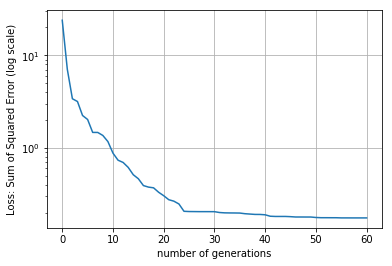

[9.98534066e-01 7.75687007e-01 3.78271618e+00 8.30727413e+01
 1.64711941e+01 8.08746343e-02 2.72836975e-02 8.16107265e+00
 3.92138141e-01 3.79050420e+03]


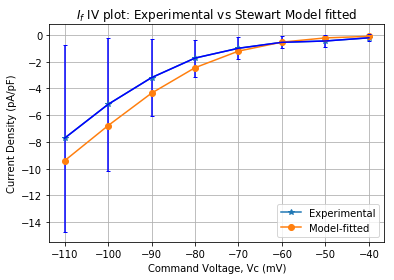

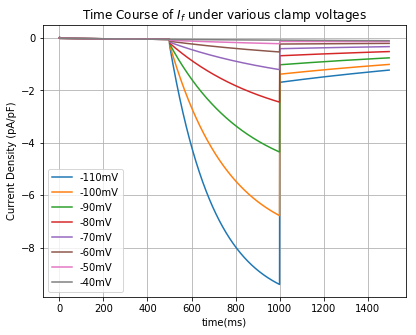

generation:  61
2
[37 77]
37
0.17483349358080516
20
generation:  62
2
[55 95]
55
0.17413517643180493
20
generation:  63
2
[29 69]
29
0.17413159522812222
20
generation:  64
2
[44 84]
44
0.17409720821979885
20
generation:  65
2
[34 74]
34
0.17070918649490957
20
Runtime:  41.77096463833344 mins
[ 1.74097208e-01  1.74097208e-01  1.74097208e-01  1.74097208e-01
  1.74097208e-01  1.74097208e-01  1.74097208e-01  1.74097208e-01
  1.74097208e-01  1.74097208e-01  1.74097208e-01  1.74097208e-01
  1.74097208e-01  1.74097208e-01  1.74097208e-01  1.74097208e-01
  1.74097208e-01  1.74097208e-01  1.74097208e-01  1.74097208e-01
  1.90819155e-01  2.36694315e+01  7.03902706e-01  1.74097208e-01
  1.74097208e-01  3.39033779e+01  1.74119484e-01  2.28845271e+01
  1.74119065e-01  2.41087674e-01  1.74097208e-01  1.79657367e-01
  1.45067427e+01  1.75755027e-01 -1.00000000e+11  1.00729604e+01
  1.82342502e+01  1.74097208e-01  2.74507055e+01  2.57929206e-01
  1.73995040e-01  1.84471992e-01  1.74097208e-01  1.74097

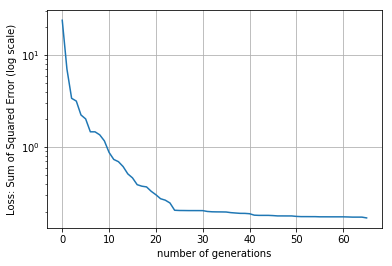

[9.98534066e-01 7.75687007e-01 3.79615911e+00 8.25366781e+01
 1.64711941e+01 8.08746343e-02 2.15724382e-02 8.16107265e+00
 3.37537465e-01 3.79978077e+03]


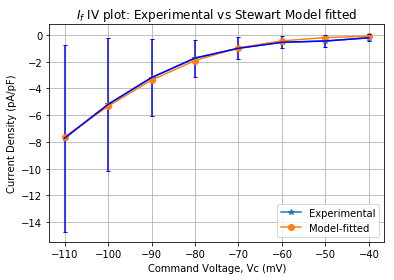

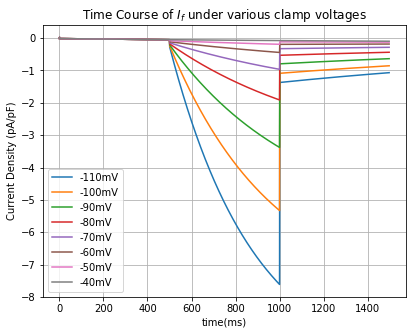

generation:  66
2
[38 78]
38
0.17029674488981972
20
generation:  67
2
[29 69]
29
0.17010769172108364
20
generation:  68
2
[56 96]
56
0.1698958116355223
20
generation:  69
2
[34 74]
34
0.16774523346767384
20
generation:  70
2
[38 78]
38
0.16151187307626108
20
Runtime:  44.7757693500001 mins
[ 1.67745233e-01  1.67745233e-01  1.67745233e-01  1.67745233e-01
  1.67745233e-01  1.67745233e-01  1.67745233e-01  1.67745233e-01
  1.67745233e-01  1.67745233e-01  1.67745233e-01  1.67745233e-01
  1.67745233e-01  1.67745233e-01  1.67745233e-01  1.67745233e-01
  1.67745233e-01  1.67745233e-01  1.67745233e-01  1.67745233e-01
  4.12752858e+00  2.14265061e+00  5.45801359e-01  1.70358658e-01
  1.67745233e-01  1.35520471e+00  2.27760738e-01  1.68128730e-01
  1.67745233e-01  1.67745233e-01  1.69679007e-01  1.65411903e-01
  9.63197820e+00  1.67745233e-01  1.66549034e-01  1.67745233e-01
  1.67738974e-01  1.15942154e+00 -1.00000000e+11  1.70013330e+00
  1.67745233e-01  1.09694347e+00  1.69814901e-01  1.6770912

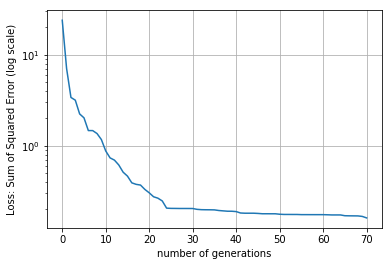

[9.98534066e-01 7.75687007e-01 3.79615911e+00 8.33346472e+01
 1.64711941e+01 1.45170875e+00 2.15724382e-02 8.16107265e+00
 2.03998624e-01 3.78648729e+03]


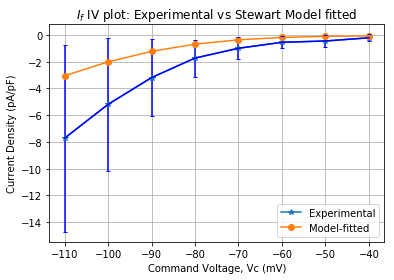

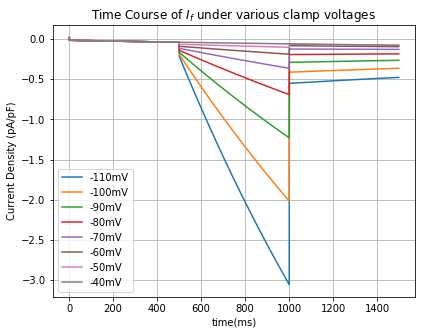

generation:  71
2
[39 79]
39
0.15987011519980185
20
generation:  72
2
[47 87]
47
0.15501325382842485
20
generation:  73
2
[41 81]
41
0.15381097083822037
20
generation:  74
42
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 26
 39 42 45 47 48 58 59 60 62 63 66 79 82 85 87 88 98 99]
0
0.15381097083822037
20
generation:  75
2
[30 70]
30
0.14921617587848213
20
Runtime:  47.821640593332994 mins
[ 1.53810971e-01  1.53810971e-01  1.53810971e-01  1.53810971e-01
  1.53810971e-01  1.53810971e-01  1.53810971e-01  1.53810971e-01
  1.53810971e-01  1.53810971e-01  1.53810971e-01  1.53810971e-01
  1.53810971e-01  1.53810971e-01  1.53810971e-01  1.53810971e-01
  1.53810971e-01  1.53810971e-01  1.53810971e-01  1.53810971e-01
  1.58505654e-01  1.53810971e-01  2.57515170e+00  1.53769977e-01
  1.98026611e-01  1.98092178e-01  1.53847512e-01  1.53810971e-01
  2.11367420e-01  8.46676924e-01 -1.00000000e+11  1.11090742e+01
  3.09356863e-01  1.67184231e-01  1.53810971e-01  2.58248708e-01


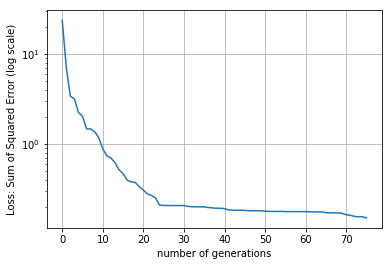

[9.98534066e-01 7.75687007e-01 3.79615911e+00 8.38138239e+01
 1.64711941e+01 8.08746343e-02 2.15724382e-02 8.16107265e+00
 1.82717815e-01 3.82767656e+03]


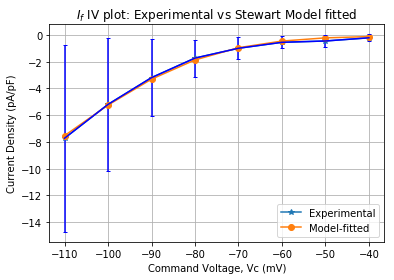

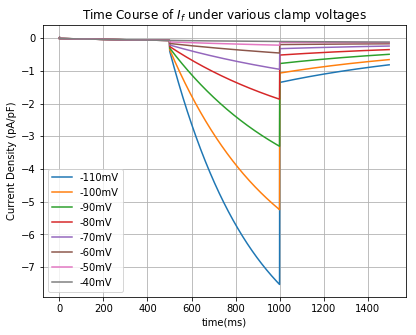

generation:  76
2
[27 67]
27
0.1382584981749519
20
generation:  77
2
[29 69]
29
0.13696498208510063
20
generation:  78
2
[22 62]
22
0.13678475827436376
20
generation:  79
2
[26 66]
26
0.1278767399288425
20
generation:  80
2
[32 72]
32
0.1217348886483536
20
Runtime:  50.799569821666715 mins
[ 1.27876740e-01  1.27876740e-01  1.27876740e-01  1.27876740e-01
  1.27876740e-01  1.27876740e-01  1.27876740e-01  1.27876740e-01
  1.27876740e-01  1.27876740e-01  1.27876740e-01  1.27876740e-01
  1.27876740e-01  1.27876740e-01  1.27876740e-01  1.27876740e-01
  1.27876740e-01  1.27876740e-01  1.27876740e-01  1.27876740e-01
  4.88387128e-01  3.42821028e+00  1.27876740e-01  1.23547870e-01
  1.30816898e-01  1.34682648e+01  1.32242004e-01  1.27876740e-01
  2.70639487e+00  7.10508480e-01  2.17907114e-01  1.10473685e+01
 -1.00000000e+11  1.23770970e-01  1.28317293e-01  1.27855875e-01
  2.91683912e+01  1.24846292e-01  1.24777844e-01  1.27876740e-01
  1.67691552e-01  1.26959536e-01  1.39298007e-01  1.8373852

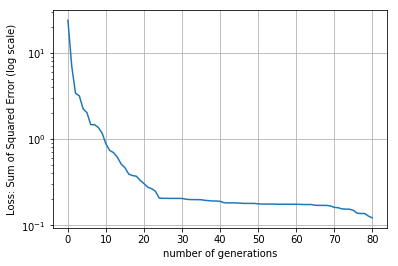

[9.98534066e-01 7.75687007e-01 3.96714198e+00 8.44334981e+01
 1.64711941e+01 8.08746343e-02 2.15724382e-02 9.92592428e+00
 1.87561399e-01 3.84665398e+03]


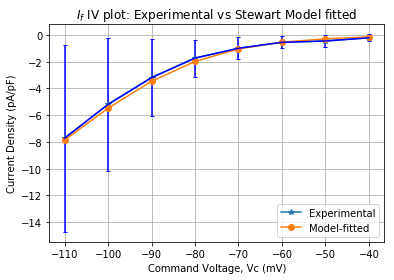

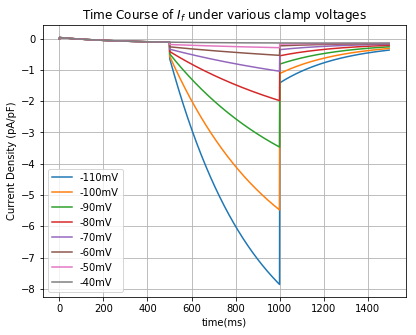

generation:  81
2
[23 63]
23
0.1163009338078062
20
generation:  82
2
[58 98]
58
0.11505179349474119
20
generation:  83
2
[26 66]
26
0.11396561097455857
20
generation:  84
2
[51 91]
51
0.11366148160111966
20
generation:  85
2
[35 75]
35
0.1113370460696827
20
Runtime:  53.91048460499975 mins
[ 1.13661482e-01  1.13661482e-01  1.13661482e-01  1.13661482e-01
  1.13661482e-01  1.13661482e-01  1.13661482e-01  1.13661482e-01
  1.13661482e-01  1.13661482e-01  1.13661482e-01  1.13661482e-01
  1.13661482e-01  1.13661482e-01  1.13661482e-01  1.13661482e-01
  1.13661482e-01  1.13661482e-01  1.13661482e-01  1.13661482e-01
  5.02872646e-01  1.43831698e+01  9.96647859e-01  1.13661482e-01
  1.76516937e+00  8.24217778e-01  1.31695145e-01  1.13661482e-01
  2.42839634e+00  1.68327922e-01  2.40168950e-01  1.13661482e-01
  1.13212091e-01  2.00806596e+00  1.29221549e-01 -1.00000000e+11
  1.18783569e-01  1.13661482e-01  1.16608427e-01  1.69522025e+00
  1.66433859e+00  8.47001212e+00  1.13661482e-01  3.2171740

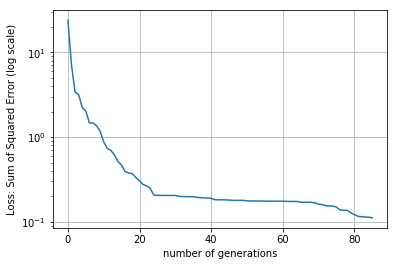

[9.98534066e-01 7.75687007e-01 5.07680002e+00 8.52042177e+01
 1.60323084e+01 8.08746343e-02 2.15724382e-02 9.92592428e+00
 1.83567935e-01 3.88105851e+03]


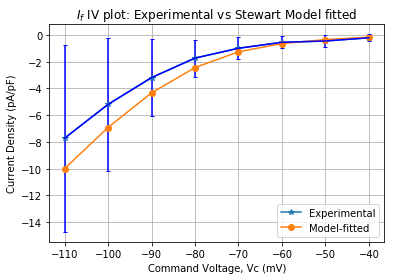

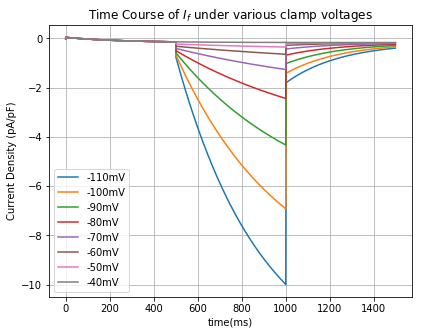

generation:  86
2
[27 67]
27
0.1024906574516033
20
generation:  87
2
[44 84]
44
0.08458176756182197
20
generation:  88
50
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 24 25 27
 30 31 32 34 37 44 49 50 52 54 55 60 64 65 67 70 71 72 74 77 84 89 90 92
 94 95]
0
0.08458176756182197
20
generation:  89
36
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 24 27 30
 35 42 58 59 62 64 67 70 75 82 98 99]
0
0.08458176756182197
20
generation:  90
34
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 34 36 37
 42 49 56 62 74 76 77 82 89 96]
0
0.08458176756182197
20
Runtime:  57.112679523333405 mins
[-1.00000000e+11  8.45817676e-02  8.45817676e-02  8.45817676e-02
  8.45817676e-02  8.45817676e-02  8.45817676e-02  8.45817676e-02
  8.45817676e-02  8.45817676e-02  8.45817676e-02  8.45817676e-02
  8.45817676e-02  8.45817676e-02  8.45817676e-02  8.45817676e-02
  8.45817676e-02  8.45817676e-02  8.45817676e-02  8.45817676e-02
  4.84112082e-01  1.97761815e+00  8.

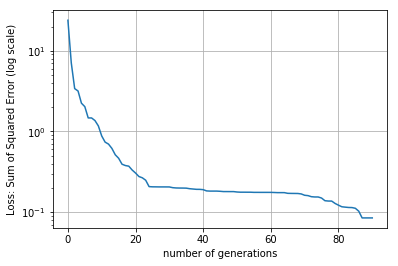

[9.98534066e-01 7.75687007e-01 3.80515151e+00 8.52042177e+01
 1.60323084e+01 8.08746343e-02 2.15724382e-02 1.09851243e+01
 1.83567935e-01 3.83961969e+03]


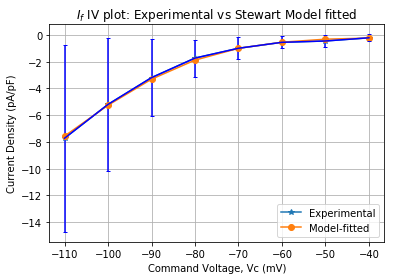

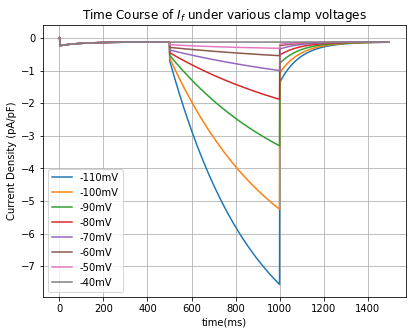

generation:  91
32
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 24 25 34 44
 48 49 64 65 74 84 88 89]
0
0.08458176756182197
20
generation:  92
36
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 26 32 36
 39 43 46 53 62 66 72 76 79 83 86 93]
0
0.08458176756182197
20
generation:  93
34
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 28 30 37
 38 44 48 62 68 70 77 78 84 88]
0
0.08458176756182197
20
generation:  94
42
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 23 25 31 35
 36 42 43 47 50 56 57 63 65 71 75 76 82 83 87 90 96 97]
0
0.08458176756182197
20
generation:  95
34
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 26 33 43 44
 45 49 51 66 73 83 84 85 89 91]
0
0.08458176756182197
20
Runtime:  60.360412113333105 mins
[-1.00000000e+11  8.45817676e-02  8.45817676e-02  8.45817676e-02
  8.45817676e-02  8.45817676e-02  8.45817676e-02  8.45817676e-02
  8.45817676e-02  8.45817676e-02  8.45817676e-02  8.45817676e-02
  

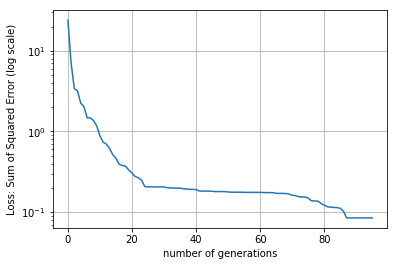

[9.98534066e-01 7.75687007e-01 3.80515151e+00 8.52042177e+01
 1.60323084e+01 8.08746343e-02 2.15724382e-02 1.09851243e+01
 1.83567935e-01 3.83961969e+03]


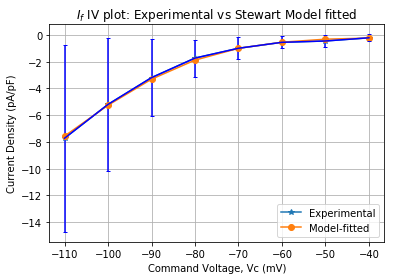

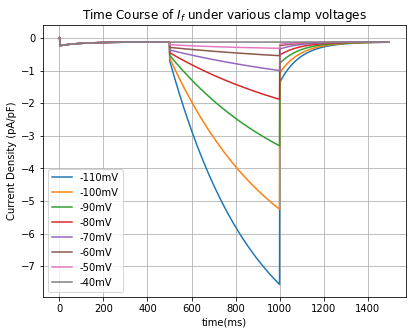

generation:  96
34
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 33 44 46
 47 50 51 60 73 84 86 87 90 91]
0
0.08458176756182197
20
generation:  97
2
[26 66]
26
0.08437491079732776
20
generation:  98
2
[37 77]
37
0.08204745267430034
20
generation:  99
2
[56 96]
56
0.07723131658359506
20
Best Solution:  [9.98534066e-01 7.75687007e-01 3.82228122e+00 8.54687357e+01
 1.60323084e+01 8.08746343e-02 2.15724382e-02 1.09590084e+01
 1.83567935e-01 3.83961969e+03]
Best solution fitness:  0.07723131658359506


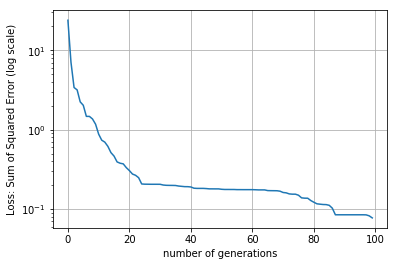

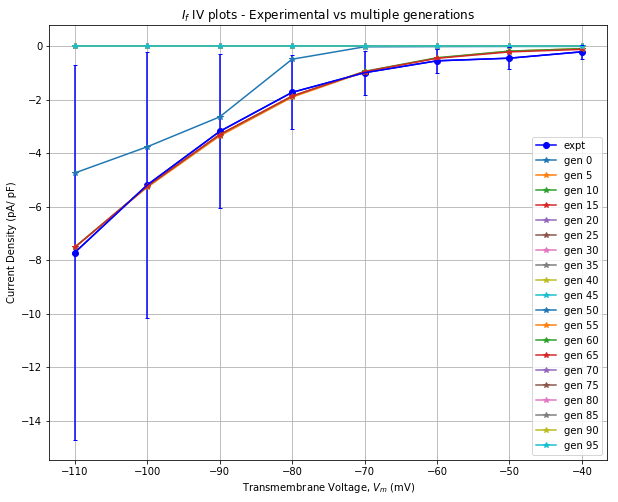

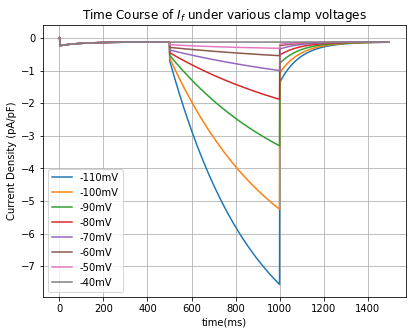

In [14]:
#If Genetic Algorithm Optimization - 100 generations
import timeit
#from sklearn.metrics import r2_score

timer_start = timeit.default_timer()

V = np.arange(-110, -39, 10)

If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

# Population
# Parameter initialization: 10
C = np.empty((100, 10))
C[:, 0] = np.random.uniform(0, 1, C.shape[0])
C[:, 1] = np.random.uniform(0, 1, C.shape[0])
C[:, 2] = np.random.uniform(0, 3, C.shape[0])
C[:, 3] = np.random.uniform(70, 90, C.shape[0])
C[:, 4] = np.random.uniform(0, 10, C.shape[0])
C[:, 5] = np.random.uniform(0, 5, C.shape[0])
C[:, 6] = np.random.uniform(0, 1, C.shape[0])
C[:, 7] = np.random.uniform(0, 5, C.shape[0])
C[:, 8] = np.random.uniform(0, 1, C.shape[0])
C[:, 9] = np.random.uniform(3800, 4100, C.shape[0])


If_cur = np.empty((C.shape[0], len(V)))
population = C  # initial Population



# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        If_cur[i,:], time, plt_If = If_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9])

    SSE = np.sum(np.power((If_cur - If_act), 2, dtype=np.float64), axis=1)
    return SSE

def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents

def crossover(parents,
              offspring_size):  # double 
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gfk
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +      #gfna
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #ayss
                         (gene_select == 3)*np.random.uniform(-10, 10) +        #byss
                         (gene_select == 4)*np.random.uniform(-2, 2) +        #cyss
                         (gene_select == 5)*np.random.uniform(-1.5, 1.5) +          #a_ay
                         (gene_select == 6)*np.random.uniform(-0.01, 0.01) +      #b_ay
                         (gene_select == 7)*np.random.uniform(-1.5, 1.5) +      #a_by
                         (gene_select == 8)*np.random.uniform(-0.05, 0.05) +          #b_by
                         (gene_select == 9)*np.random.uniform(-50, 50)    #a_tau
                         )
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 100
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((8, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
    print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
    print(best_gn_fit_idx[0].size)
    print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
    print(indx)
    print(fitness[indx])
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
    print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fitness)
        plt.plot(gen_num, best_gen_fitness)
        plt.xlabel('number of generations')
        plt.ylabel('Loss: Sum of Squared Error (log scale)')
        plt.yscale('log')
        plt.grid()
        plt.show()
        y_fit, time_fit, plt_If_fit = If_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9])
        gen_curr_arr[:, i_plt] = y_fit
        print(population[indx, :])
        plt.figure()
        plt.plot(V, If_act, '-*', V, y_fit, '-o')
        plt.legend(['Experimental', 'Model-fitted'], loc='best')
        plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
        plt.xlabel('Command Voltage, Vc (mV)')
        plt.ylabel('Current Density (pA/pF)')
        plt.title('${I_f}$ IV plot: Experimental vs Stewart Model fitted')
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(6.5, 5))
        plt.plot(time_fit, plt_If_fit)
        plt.xlabel('time(ms)')
        plt.ylabel('Current Density (pA/pF)')
        plt.title('Time Course of $I_f$ under various clamp voltages')
        plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
        plt.grid()
        plt.show()

        i_plt = i_plt + 1
        
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
print("Best Solution: ", population[best_match_idx[0][0], :])
print("Best solution fitness: ", fitness[best_match_idx[0][0]])

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error (log scale)')
plt.grid()
plt.show()

plt.figure(figsize = (10,8))
plt.plot(V, If_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Experimental vs multiple generations')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5, 5))
plt.plot(time_fit, plt_If_fit)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under various clamp voltages')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.show()

Initial Model Goodness of fit, R_sq = -0.3642773505765353
GA fitted Model Goodness of fit, R_sq = 0.9984870584617149
percent change: [ 4.16093924e+03  5.22554552e+03  2.82228122e+02  6.04061501e+00
  1.35769241e+02 -9.72112195e+01 -4.60689045e+01  2.04416900e+02
  6.68799409e+01 -4.00950775e+00]


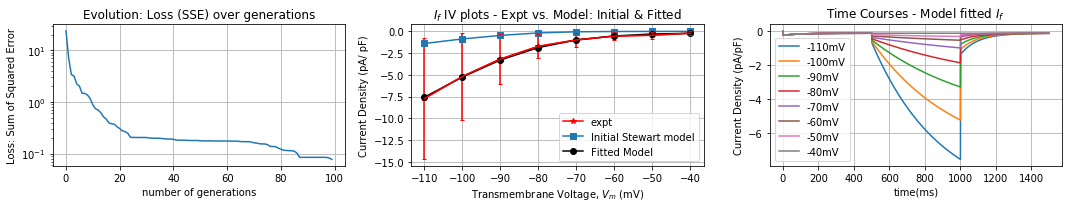

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(9.98534066e-01, 7.75687007e-01, 3.82228122e+00, 8.54687357e+01,
 1.60323084e+01, 8.08746343e-02, 2.15724382e-02, 1.09590084e+01,
 1.83567935e-01, 3.83961969e+03)
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

ini_param = np.array([0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000])
fin_param = np.array([9.98534066e-01, 7.75687007e-01, 3.82228122e+00, 8.54687357e+01,
 1.60323084e+01, 8.08746343e-02, 2.15724382e-02, 1.09590084e+01,
 1.83567935e-01, 3.83961969e+03])
percent_change = ((fin_param - ini_param)/ini_param)*100

print('percent change:', percent_change)

plt.figure(figsize= (15,3))
plt.subplot(1,3,3)
plt.plot(time, Iffit_time)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Courses - Model fitted $I_{f}$')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Vcm, If_act, 'r-*', label = 'expt') #experimental plot
plt.plot(Vcm, IfIni, '-s', label='Initial Stewart model')  #initial model plot
plt.plot(Vcm, Iffit, 'k-o', label='Fitted Model') #modelfitted
plt.errorbar(Vcm, If_act, yerr=If_err, capsize=2, color = 'red') #errorbar experimental data
plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Expt vs. Model: Initial & Fitted')
plt.grid()
plt.legend(loc='best')

plt.subplot(1,3,1)
gen_num = np.arange(len(best_gen_fitness))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.title('Evolution: Loss (SSE) over generations')
plt.grid()
plt.tight_layout()
plt.show()
